Import libraries

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

Load the image and convert it to grayscale

In [3]:
image = cv2.imread('image_path.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

Apply a binary threshold to the image

In [4]:
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

Remove noise using morphological operations

In [5]:
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

Get sure background area using dilation

In [10]:
sure_bg = cv2.dilate(opening, kernel, iterations=3)

Perform distance transform and thresholding to find sure foreground area

In [11]:
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

Find unknown region (area that is neither background nor foreground)

In [12]:
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

Perform marker labeling

In [13]:
_, markers = cv2.connectedComponents(sure_fg)

Add one to all labels to distinguish sure background from unknown regions

In [14]:
markers = markers + 1

Mark the unknown region with zero

In [15]:
markers[unknown == 255] = 0

Apply the watershed algorithm

In [16]:
markers = cv2.watershed(image, markers)

Mark boundaries in the original image

In [19]:
image[markers == -1] = [0, 255, 0]  # Green boundaries

Display the result

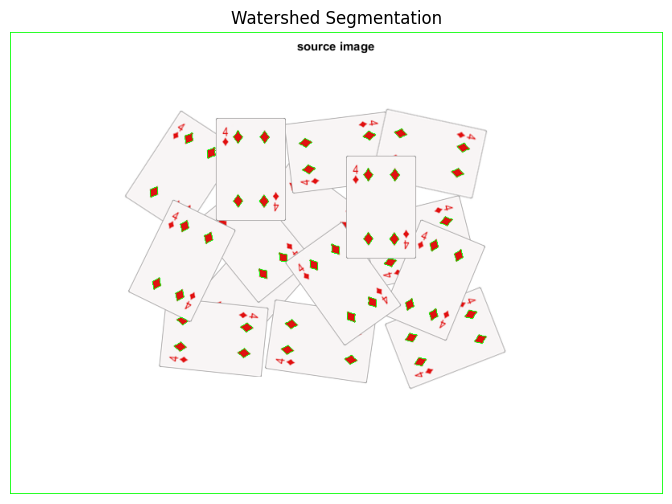

In [20]:
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Watershed Segmentation')
plt.show()